## XGBoost EVI Negative Breaks

Peter R., 2023-07-27

In [11]:
# Import the os module
import os

# Get the current working directory
cwd = os.getcwd()

print(cwd)

C:\Users\Peter R\Documents\xgboost\tutorial


In [47]:
# Set up libraries
from numpy import loadtxt

from sklearn.datasets import load_iris

iris = load_iris()
# load data
evi = loadtxt(r'.\data\forest_drivers1.csv', delimiter=',')
evi2 = loadtxt(r'.\data\forest_drivers_unk1.csv', delimiter=',')

numSamples, numFeatures = evi.data.shape

print(numSamples)
print(numFeatures)
print(list(iris.target_names))

174
9
['setosa', 'versicolor', 'virginica']


In [166]:
import pandas as pd
#from pandas import read_csv

df1 = pd.read_csv(r'.\data\forest_drivers1.csv')
df1.head()

,-765,56.42,24.7,74.8,0,373,813,4.40,0.1
0,-432,34.42,22.7,76.7,0,374,813,4.40,0
1,-614,53.18,18.5,78.8,0,380,1018,5.06,0
2,-276,72.76,70.2,29.5,0,454,998,4.22,0
3,-291,88.82,29.7,30.7,0,167,819,6.90,0
4,-1190,81.18,85.0,14.9,0,363,1024,4.29,0


In [32]:
#print(iris.data[:3, :])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]]


In [49]:
# split data into X and y
X1 = evi[:,0:8]
Y1 = evi[:,8]

# New data
X2 = evi2[:,0:7]
#Y1 = evi2[:,7]

In [34]:
#print(iris.target[:50])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


([], [])

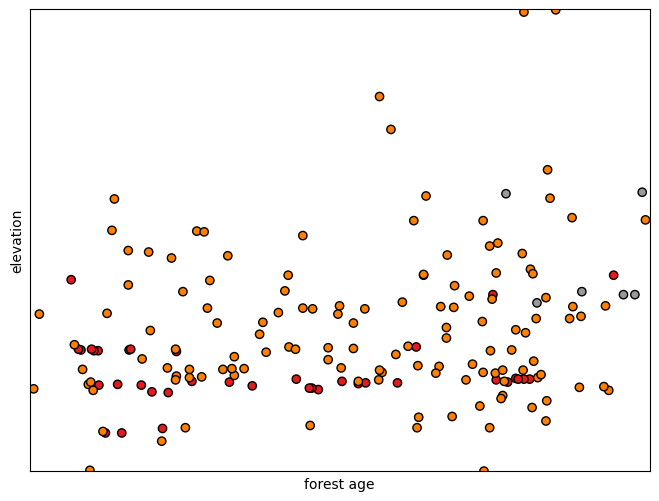

In [45]:
import matplotlib.pyplot as plt

# import some data to play with
X = evi[:, [2,6]]  # we only take the first two features.
y = Y1

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("forest age")
plt.ylabel("elevation")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

In [8]:
#from sklearn.model_selection import train_test_split

#x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=0)

In [134]:
# using EVI breaks
from sklearn.model_selection import train_test_split

seed = 7
testsize1 = 0.2

# to help deal with unbalanced data use stratify=yes. But don't use here yet.
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=testsize1, random_state=seed)



In [136]:
sum(y_train)/len(y_train) # values should be the same as below


0.7985611510791367

In [137]:

sum(y_test)/len(y_test)

0.9142857142857143

Load xgboost

In [36]:
import xgboost as xgb

# Model 1: Baseline model
train = xgb.DMatrix(x_train, label=y_train)
test = xgb.DMatrix(x_test, label=y_test)

# Model 1: uses train() and parameters below

# change parameters accordingly. Ideally, do a sensitivity test with GridSearch
param = {
    'max_depth': 4,
    'eta':0.3,
    'objective': 'multi:softmax',
    'num_class': 3}

epochs = 10

# train() defaults to 'multisoftmax' when more than two classes are found in y_train.
model = xgb.train(param, train, epochs)


In [155]:
# Model 1_2: This model includes weights to help with imbalanced data
# Weights acn help for imbalanced data
from sklearn.utils import class_weight

weights1  = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

print(y_train[:3])
print(weights1[:3])

train2 = xgb.DMatrix(x_train, label=y_train, weight=weights1)

# Model 1_2: uses train() and default parameters and weights
# train() defaults to 'multisoftmax' when more than two classes are found in y_train.
model1_2 = xgb.train(param, train2, epochs)

[1. 0. 1.]
[0.45874587 1.4040404  0.45874587]


Test the model with brand new data

In [188]:
# DElete. not needed
# This is the brand new data to test how well the model does.
# in this data set I don't have a label
testNewData = xgb.DMatrix(X2)
print(testNewData)

Now let's run the model

In [38]:
# Model 1: uses train() and default parameters
# train() defaults to 'multisoftmax' when more than two classes are found in y_train.
#model = xgb.train(param, train, epochs)

In [149]:
# Model 2: uses XGBClassifier for more flexibility. Note: XGBClassifier does not need DMatrix
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix

x2_train, x2_test, y2_train, y2_test = train_test_split(X1, Y1, test_size=testsize1, random_state=seed, stratify=y)

print(sum(y2_train)/len(y2_train)) # values should be the same as below

print(sum(y2_test)/len(y2_test))

# Model using the XGBClassifier wrapper
# You can't use scale_pos_weight when dealting with multinomial/multiclass data. Only works with binary.
model2 = xgb.XGBClassifier(objective='multi:softmax', seed=seed, eval_metric='aucpr', early_stopping_rounds=10) # scale_pos_weight on?
model2.fit(x2_train, y2_train, verbose=True, eval_set= [(x2_test, y2_test)])

0.8273381294964028
0.8
[0]	validation_0-aucpr:0.61718
[1]	validation_0-aucpr:0.66632
[2]	validation_0-aucpr:0.67090
[3]	validation_0-aucpr:0.67741
[4]	validation_0-aucpr:0.67544
[5]	validation_0-aucpr:0.71241
[6]	validation_0-aucpr:0.70939
[7]	validation_0-aucpr:0.70884
[8]	validation_0-aucpr:0.93846
[9]	validation_0-aucpr:0.93846
[10]	validation_0-aucpr:0.93989
[11]	validation_0-aucpr:0.94103
[12]	validation_0-aucpr:0.94745
[13]	validation_0-aucpr:0.95396
[14]	validation_0-aucpr:0.94971
[15]	validation_0-aucpr:0.95549
[16]	validation_0-aucpr:0.95525
[17]	validation_0-aucpr:0.95324
[18]	validation_0-aucpr:0.95592
[19]	validation_0-aucpr:0.95592
[20]	validation_0-aucpr:0.95592
[21]	validation_0-aucpr:0.95592
[22]	validation_0-aucpr:0.95714
[23]	validation_0-aucpr:0.95714
[24]	validation_0-aucpr:0.95998
[25]	validation_0-aucpr:0.95998
[26]	validation_0-aucpr:0.95998
[27]	validation_0-aucpr:0.95998
[28]	validation_0-aucpr:0.95714
[29]	validation_0-aucpr:0.95714
[30]	validation_0-aucpr:0.9

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

Fine tune parameters to find a better model (potentially)

In [142]:
# Fine tune parameters using GridSearchCV. This won't work becasue of the limitation of the data

# Model 3: GridSearch Model
param_grid1 = {
'max_depth' : [3,4,5],
'learning_rate': [0.1, 0.01, 0.05],
'gamma': [0, 0.25, 1.0],
'reg_lambda': [0, 1.0, 10.0],
}


# grid_search is my new model
# subsample is for running the model faster
model3 = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='multi:softmax', seed=seed, eval_metric='aucpr', subsample=0.9,  colsample_bytree=0.5) ,
    param_grid=param_grid1,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 3, #Can't be bigger than the number of records per group
    verbose=True
)

model3.fit(x2_train, y2_train)

#model3.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


C:\Users\Peter R\anaconda3\envs\xgboost1\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softmax', predictor=None, ...)

Now let's test predictions

In [182]:
predictions = model.predict(test)
print(predictions)

[1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1.]


In [167]:
predictions1_2 = model1_2.predict(test)
print(predictions1_2)

[1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1.]


In [174]:
# can't use matrices with DMatrix
predictions2 = model2.predict(x2_test)
print(predictions2)

[1 1 1 1 1 1 1 2 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 2 1 2 1 1]


In [178]:
# Prediction using new data (not initial train or test data)
predictionsNew = model.predict(testNewData)

In [179]:
print(predictionsNew)

[1. 1. 0. 2. 1. 2. 1. 1. 1. 0. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 2. 1. 1. 0. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1.]


Let's measure the accuracy

In [181]:
from sklearn.metrics import accuracy_score #0.9142857142857143

print('model1:', accuracy_score(y_test, predictions))
print(accuracy_score(y_test, predictions1_2))
print(accuracy_score(y2_test, predictions2)) # All the same? SO stratify does not help?

model1 0.9142857142857143
0.9142857142857143
0.9142857142857143


In [180]:
from sklearn.metrics import accuracy_score

accuracy_score(y2_test, predictions2)

0.9142857142857143

In [153]:
# Cross-Validation model - Does not work yet
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model4 = xgb.XGBClassifier() #Why do I have to give it a new empty model

kfold = KFold(n_splits=10) #(... , random_state=seed, shuffle=True)
results = cross_val_score(model4, X1, Y1, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 80.16% (23.28%)


In [151]:
# Cross-Validation model - Does not work yet
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

model4 = xgb.XGBClassifier() # new deafult model

kfold = KFold(n_splits=10) #(... , random_state=seed, shuffle=True)
results = cross_val_score(model4, X1, Y1, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 80.16% (23.28%)


{'f0': 0.7902762293815613, 'f1': 0.8968190550804138, 'f2': 0.7901024222373962, 'f3': 2.1240828037261963, 'f5': 1.7510524988174438, 'f6': 2.3464765548706055, 'f7': 1.7616039514541626}


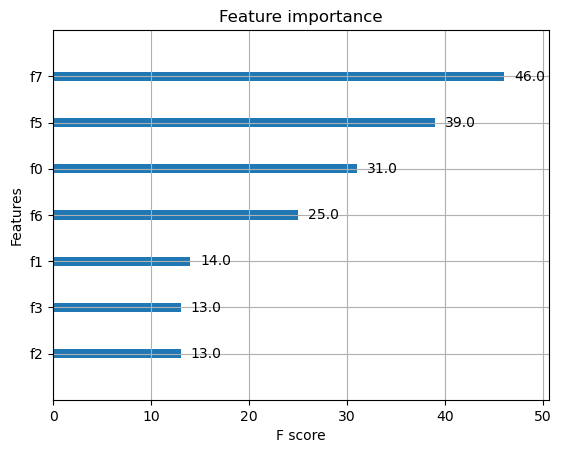

In [69]:
# feature importance
print(model.get_score(importance_type='gain'))

# plot
xgb.plot_importance(model, max_num_features=10)
plt.show()

{'f0': 1.1051844358444214, 'f1': 0.43424034118652344, 'f2': 0.9394307732582092, 'f3': 2.7889046669006348, 'f5': 5.488593101501465, 'f6': 2.5869030952453613, 'f7': 2.2757599353790283}


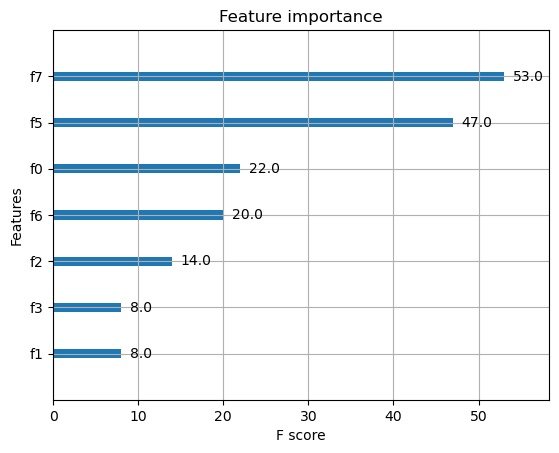

In [156]:
# feature importance
print(model1_2.get_score(importance_type='gain'))

# plot
xgb.plot_importance(model1_2, max_num_features=10)
plt.show()

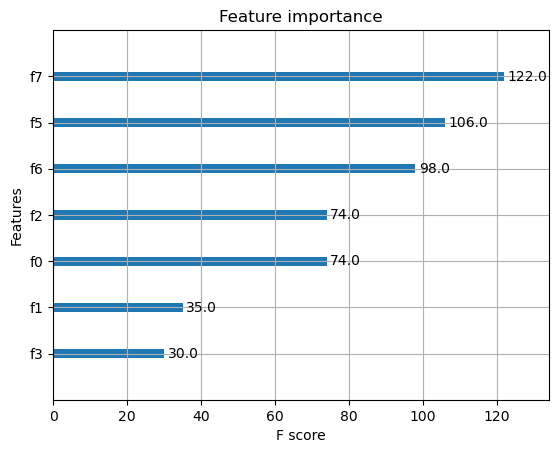

In [164]:
# feature importance. Error: 'XGBClassifier' object has no attribute 'get_score'

#print(model2.get_fscore(importance_type='gain'))

xgb.plot_importance(model2, max_num_features=10)
plt.show()

# plot
#xgb.plot_importance(model2, max_num_features=10)
#plt.show()

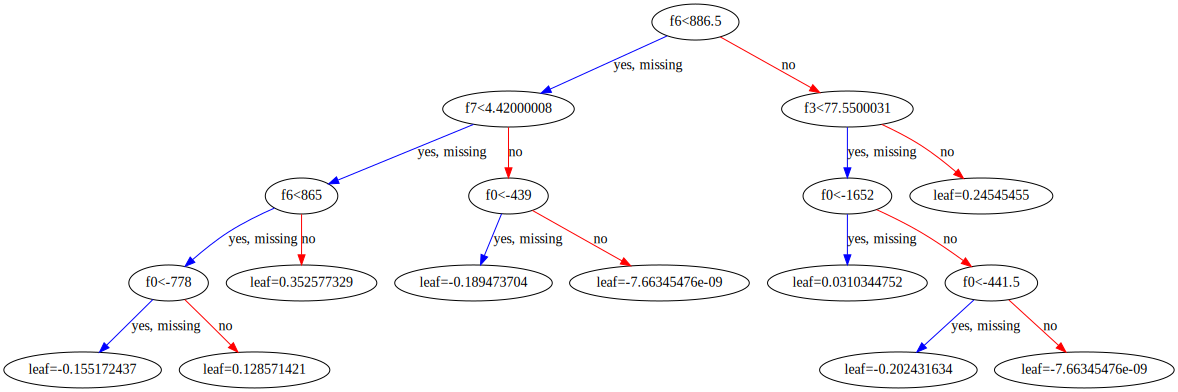

In [106]:
# Plot tree. (Note: I havd to install graphviz from the conda cmd line)
import graphviz

#fig, ax = plt.subplots(figsize=(8, 6)) #plt.figure(2, figsize=(8, 6))
#xgb.plot_tree(model, num_trees=4)

xgb.to_graphviz(model, size=6)


This example worked. See tutorials:
https://www.youtube.com/watch?v=OQKQHNCVf5k
https://www.youtube.com/watch?v=GrJP9FLV3FE&t=2167s
https://datascience.stackexchange.com/questions/16342/unbalanced-multiclass-data-with-xgboost


In [89]:

#dot = graphviz.Graph()

#dot.node('A')
#dot.node('B')
#dot.edge('A', 'B')

#dot.render('graph', view=True) # this creates a pdf by defaul


'graph.pdf'